
# UNICEF Data and Analytics P3 Technical Evaluation

## Introduction

This report presents the analysis conducted as part of the UNICEF Data and Analytics P3 technical evaluation. The primary objective of this assessment is to calculate the population-weighted coverage of health services, specifically antenatal care (ANC4) and skilled birth attendance (SAB), for countries classified as either on-track or off-track in achieving the under-5 mortality targets as of 2023.

### Background

The Strategic Data Analytics Team, to which this analysis pertains, is responsible for providing fast, concise, and insightful data analytics on key topics to support high-level technical management. This analysis aims to contribute to understanding the progress of countries towards achieving Sustainable Development Goal (SDG) targets related to under-5 mortality.

### Objectives

The specific objectives of this analysis are:

1. To clean and merge datasets related to antenatal care, skilled birth attendance, population data, and under-5 mortality classifications.
2. To calculate the most recent population-weighted coverage estimates for antenatal care (ANC4) and skilled birth attendance (SAB) from 2018 to 2022.
3. To compare the population-weighted coverage estimates between countries classified as on-track and off-track in achieving under-5 mortality targets.
4. To visualize the differences in coverage estimates and provide insights into the findings.

### Data Sources

The analysis utilizes the following data sources:

1. **Antenatal care 4+ visits (ANC4)** - Percentage of women (aged 15-49 years) attended at least four times during pregnancy by any provider.
2. **Skilled Birth Attendant (SAB)** - Percentage of deliveries attended by skilled health personnel.
3. **Population Data** - United Nations World Population Prospects estimates.
4. **Under-Five Mortality Classification** - Data provided by the United Nations Inter-agency Group for Child Mortality Estimation (UN IGME).

These data sources have been integrated and analyzed to provide meaningful insights into the progress of countries towards achieving health-related SDG targets.

### Methodology

The methodology involves data cleaning, merging datasets, filtering for the most recent coverage estimates, and calculating population-weighted coverage for both on-track and off-track countries. The results are then visualized to compare the differences in health service coverage.



## Libraries Used

- **pandas**: For data manipulation and analysis.
- **numpy**: For numerical computations.
- **matplotlib** and **seaborn**: For data visualization.
- **sklearn.cluster.KMeans**: For clustering analysis.

These libraries facilitate efficient data processing, analysis, and visualization.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

## Custom Function: `read_excel_safe`

A custom function `read_excel_safe` was implemented to handle the reading of Excel files with built-in error handling. This function is essential for ensuring that the analysis can proceed smoothly even if some files have issues during loading.


In [2]:
# Function to read Excel files with error handling
def read_excel_safe(file_path, **kwargs):
    try:
        return pd.read_excel(file_path, **kwargs)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return None

## Custom Function: `get_latest_value`

The `get_latest_value` function is designed to retrieve the most recent valid value from a row of data across multiple years. This function is critical for ensuring that the analysis uses the latest available data for each country.


In [3]:
# Function to get the latest value
def get_latest_value(row):
    for year in ['2022', '2021', '2020', '2019', '2018']:
        if pd.notna(row[year]) and row[year] != '-':
            return float(row[year])
    return np.nan

## Custom Function: `weighted_average`

The `weighted_average` function is used to calculate the population-weighted average for a given group of data. This is particularly useful when analyzing data across countries with varying population sizes to ensure that larger populations have a proportional impact on the average.


In [4]:
# Function to calculate weighted average
def weighted_average(group, value_col, weight_col):
    return (group[value_col] * group[weight_col]).sum() / group[weight_col].sum()

## Data Loading and Preparation

To begin the analysis, the necessary data files were loaded into the environment using the `read_excel_safe` function, which includes error handling to ensure that any issues during file loading are properly managed. The following files were utilized:

- **Population Data**: `WPP2022_GEN_F01_DEMOGRAPHIC_INDICATORS_COMPACT_REV1.xlsx` (Sheet: "Projections")
- **Country Classification Data**: `On-track and off-track countries.xlsx`
- **Health Coverage Data**: `GLOBAL_DATAFLOW_2018-2022.xlsx`


In [5]:
# Data Loading and Preparation
population_data = read_excel_safe('WPP2022_GEN_F01_DEMOGRAPHIC_INDICATORS_COMPACT_REV1.xlsx', 
                                  sheet_name='Projections', header=16)
country_data = read_excel_safe('On-track and off-track countries.xlsx')
coverage_data = read_excel_safe('GLOBAL_DATAFLOW_2018-2022.xlsx', skiprows=2)

if population_data is None or country_data is None or coverage_data is None:
    raise ValueError("One or more required files could not be read.")

## Data Cleaning and Merging

After loading the datasets, the next step involved cleaning and preparing the data for analysis. This included renaming columns for clarity and extracting relevant subsets of data.


In [6]:
# Data Cleaning and Merging
coverage_data.columns = ['Geographic area', 'Indicator', 'Sex', '2022', '2021', '2020', '2019', '2018']
births_2022 = population_data[population_data['Year'] == 2022][['Region, subregion, country or area *', 'ISO3 Alpha-code', 'Births (thousands)']]

## Filtering Coverage Data

To ensure the analysis is focused on relevant countries, the health coverage data was filtered to include only those countries that are present in the country classification dataset (on-track and off-track countries).


In [7]:
# Filter coverage data
filtered_coverage_data = coverage_data[coverage_data['Geographic area'].isin(country_data['OfficialName'])]

## Extracting Latest Coverage Values

To analyze the most recent health service coverage data, the latest available value for each country was extracted from the filtered dataset. This step ensures that the analysis uses the most up-to-date information.


In [8]:
# Get latest values
filtered_coverage_data['latest_value'] = filtered_coverage_data.apply(get_latest_value, axis=1)

C:\Users\mashhadcom.com\AppData\Local\Temp\ipykernel_29104\3589703117.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_coverage_data['latest_value'] = filtered_coverage_data.apply(get_latest_value, axis=1)


## Separating ANC4 and SAB Data

To facilitate focused analysis, the filtered coverage data was separated into two distinct datasets: one for antenatal care with at least four visits (ANC4) and another for skilled birth attendance (SAB). This step allows for more targeted analysis of each health service indicator.


In [9]:
# Separate ANC4 and SAB data
anc4_data = filtered_coverage_data[filtered_coverage_data['Indicator'].str.contains('Antenatal care 4\+ visits', case=False, na=False)]
sab_data = filtered_coverage_data[filtered_coverage_data['Indicator'].str.contains('Skilled birth attendant', case=False, na=False)]

## Preparing the Final Dataset

To perform a comprehensive analysis of health service coverage, the data for antenatal care (ANC4) and skilled birth attendance (SAB) were merged into a single dataset. This final dataset combines the latest available coverage values for both indicators across all relevant countries.


In [10]:
# Prepare final dataset
final_data = pd.merge(anc4_data[['Geographic area', 'latest_value']], 
                      sab_data[['Geographic area', 'latest_value']], 
                      on='Geographic area', suffixes=('_ANC4', '_SAB'), how='outer')

## Merging with Births Data and Country Status

To enrich the final dataset with additional context, it was merged with data on births in 2022 and the under-5 mortality rate status (on-track or off-track). This provides the necessary information to calculate population-weighted coverage and to analyze the relationship between health service coverage and progress towards under-5 mortality targets.


In [11]:
# Merge with births data and country status
final_data = pd.merge(final_data, births_2022, left_on='Geographic area', right_on='Region, subregion, country or area *', how='left')
final_data = pd.merge(final_data, country_data[['OfficialName', 'Status.U5MR']], left_on='Geographic area', right_on='OfficialName', how='left')

## Categorization of On-Track and Off-Track Countries

To simplify the analysis, countries were categorized as either "on-track" or "off-track" based on their under-5 mortality rate status. This categorization is crucial for comparing health service coverage between these two groups.


In [12]:
# Correct categorization of on-track and off-track countries
final_data['Status'] = final_data['Status.U5MR'].apply(lambda x: 'on-track' if x in ['Achieved', 'On Track'] else 'off-track')

## Data Quality Check

Before proceeding with the analysis, a data quality check was performed to identify any missing values and to assess the distribution of countries categorized as on-track and off-track. This step is crucial to ensure that the dataset is reliable and to understand the potential impact of any missing data.


In [13]:
# Data Quality Check
print("Missing values in final dataset:")
print(final_data.isnull().sum())
print("\nCountry status distribution:")
print(final_data['Status'].value_counts())

Missing values in final dataset:
Geographic area                          0
latest_value_ANC4                       61
latest_value_SAB                         8
Region, subregion, country or area *     2
ISO3 Alpha-code                          2
Births (thousands)                       2
OfficialName                             0
Status.U5MR                              0
Status                                   0
dtype: int64

Country status distribution:
Status
on-track     101
off-track     41
Name: count, dtype: int64



Here's a concise markdown description for the result:

markdown
Copy code
### Data Quality Check Results

The data quality check revealed the following:

- **Missing Data**:
  - `latest_value_ANC4`: 61 missing values, indicating significant gaps in antenatal care coverage data.
  - `latest_value_SAB`: 8 missing values, suggesting relatively complete data for skilled birth attendance.
  - `Region, subregion, country or area *`, `ISO3 Alpha-code`, `Births (thousands)`: Each has 2 missing values, which may affect weighted calculations.

- **Country Status Distribution**:
  - 101 countries are classified as **on-track**.
  - 41 countries are classified as **off-track**.

These findings highlight the need to address missing data, particularly in ANC4, and provide a basis for comparing coverage between on-track and off-track countries.

In [14]:
# Count countries with different data availability
anc4_only = final_data['latest_value_ANC4'].notna() & final_data['latest_value_SAB'].isna()
sab_only = final_data['latest_value_ANC4'].isna() & final_data['latest_value_SAB'].notna()
both = final_data['latest_value_ANC4'].notna() & final_data['latest_value_SAB'].notna()

print("Countries with only ANC4 data:", anc4_only.sum())
print("Countries with only SAB data:", sab_only.sum())
print("Countries with both ANC4 and SAB data:", both.sum())

Countries with only ANC4 data: 8
Countries with only SAB data: 61
Countries with both ANC4 and SAB data: 73


## Identifying Countries with Missing Birth Data

To ensure accurate population-weighted calculations, it is essential to address any missing birth data. The following steps were taken to identify and potentially resolve these issues.


In [15]:
# Identify countries with missing birth data
countries_without_births = final_data[final_data['Births (thousands)'].isna()]['Geographic area']
print("Countries without birth data:")
print(countries_without_births.tolist())

# Check if these countries exist in the population data
for country in countries_without_births:
    matching_countries = population_data[population_data['Region, subregion, country or area *'].str.contains(country, case=False, na=False)]
    if not matching_countries.empty:
        print(f"\nPossible matches for {country} in population data:")
        print(matching_countries['Region, subregion, country or area *'].tolist())
    else:
        print(f"\nNo match found for {country} in population data")

# Check unique country names in population data
unique_countries_pop = population_data['Region, subregion, country or area *'].unique()
print("\nUnique country names in population data:")
print(unique_countries_pop)

Countries without birth data:
['Kosovo (UNSCR 1244)', 'United States']

No match found for Kosovo (UNSCR 1244) in population data

Possible matches for United States in population data:
['United States Virgin Islands', 'United States Virgin Islands', 'United States Virgin Islands', 'United States Virgin Islands', 'United States Virgin Islands', 'United States Virgin Islands', 'United States Virgin Islands', 'United States Virgin Islands', 'United States Virgin Islands', 'United States Virgin Islands', 'United States Virgin Islands', 'United States Virgin Islands', 'United States Virgin Islands', 'United States Virgin Islands', 'United States Virgin Islands', 'United States Virgin Islands', 'United States Virgin Islands', 'United States Virgin Islands', 'United States Virgin Islands', 'United States Virgin Islands', 'United States Virgin Islands', 'United States Virgin Islands', 'United States Virgin Islands', 'United States Virgin Islands', 'United States Virgin Islands', 'United State

C:\Users\mashhadcom.com\AppData\Local\Temp\ipykernel_29104\1029715526.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matching_countries = population_data[population_data['Region, subregion, country or area *'].str.contains(country, case=False, na=False)]


In [47]:
final_data

,Geographic area,latest_value_ANC4,latest_value_SAB,ISO3 Alpha-code,Births (thousands),Status.U5MR,Status,gap,ANC4_SAB_ratio,Cluster,ANC4_SAB_gap
0,Afghanistan,27.6,61.8,AFG,1446.699,Acceleration Needed,off-track,34.2,0.446602,2.0,34.2
1,Albania,77.8,99.8,ALB,28.795,Achieved,on-track,22.0,0.779559,0.0,22.0
2,Algeria,69.8,98.8,DZA,923.648,Achieved,on-track,29.0,0.706478,0.0,29.0
3,Argentina,90.4,98.8,ARG,627.741,Achieved,on-track,8.4,0.914980,0.0,8.4
4,Bangladesh,36.9,59.0,BGD,2994.966,On Track,on-track,22.1,0.625424,2.0,22.1
...,...,...,...,...,...,...,...,...,...,...,...
137,Slovakia,NaN,98.0,SVK,53.357,Achieved,on-track,NaN,NaN,NaN,NaN
138,Spain,NaN,99.9,ESP,356.359,Achieved,on-track,NaN,NaN,NaN,NaN
139,United Arab Emirates,NaN,99.2,ARE,93.343,Achieved,on-track,NaN,NaN,NaN,NaN
140,United States,NaN,99.1,NaN,NaN,Achieved,on-track,NaN,NaN,NaN,NaN


## Country Name Mapping and Final Data Quality Check

To resolve discrepancies between country names across datasets and ensure the completeness of the final dataset, a mapping function was implemented. Additionally, a final check was conducted to assess the completeness of the data after applying the country name corrections.


In [16]:
# country_name_mapping
country_name_mapping = {
    'Kosovo (UNSCR 1244)': 'Kosovo (under UNSC res. 1244)',
    'United States': 'United States of America'
}

# Function to map country names
def map_country_name(name):
    return country_name_mapping.get(name, name)

# Check for countries without birth data
countries_without_births = final_data[final_data['Births (thousands)'].isna()]['Geographic area']
print("Countries still without birth data:")
print(countries_without_births.tolist())

# Print the first few rows of the updated final_data
print("\nUpdated final_data:")
print(final_data.head())

# Print the number of countries with complete data
complete_data = final_data.dropna(subset=['latest_value_ANC4', 'latest_value_SAB', 'Births (thousands)'])
print(f"\nNumber of countries with complete data: {len(complete_data)}")

# Display general information about final_data
print("\nInformation about final_data:")
print(final_data.info())

# Display the number of null values in each column
print("\nNumber of null values in each column:")
print(final_data.isnull().sum())

Countries still without birth data:
['Kosovo (UNSCR 1244)', 'United States']

Updated final_data:
  Geographic area  latest_value_ANC4  latest_value_SAB   
0     Afghanistan               27.6              61.8  \
1         Albania               77.8              99.8   
2         Algeria               69.8              98.8   
3       Argentina               90.4              98.8   
4      Bangladesh               36.9              59.0   

  Region, subregion, country or area * ISO3 Alpha-code Births (thousands)   
0                          Afghanistan             AFG           1446.699  \
1                              Albania             ALB             28.795   
2                              Algeria             DZA            923.648   
3                            Argentina             ARG            627.741   
4                           Bangladesh             BGD           2994.966   

  OfficialName          Status.U5MR     Status  
0  Afghanistan  Acceleration Needed  off-

## Final Data Cleanup and Overview

To finalize the dataset for analysis, unnecessary and duplicate columns were removed, and the remaining columns were cleaned and converted to appropriate data types. A final check was conducted to ensure the dataset's integrity and completeness.


In [17]:
# Remove duplicate and unnecessary columns
columns_to_keep = ['Geographic area', 'latest_value_ANC4', 'latest_value_SAB', 
                   'ISO3 Alpha-code', 'Births (thousands)', 'Status.U5MR', 'Status']
final_data = final_data[columns_to_keep]

# Convert 'Births (thousands)' to float
final_data['Births (thousands)'] = final_data['Births (thousands)'].astype(float)

# Display updated information
print("Updated information about final_data:")
print(final_data.info())

print("\nNumber of null values in each column:")
print(final_data.isnull().sum())

print("\nDistribution of country statuses:")
print(final_data['Status'].value_counts())

print("\nNumber of countries with ANC4 data:", final_data['latest_value_ANC4'].notna().sum())
print("Number of countries with SAB data:", final_data['latest_value_SAB'].notna().sum())
print("Number of countries with both ANC4 and SAB data:", 
      final_data.dropna(subset=['latest_value_ANC4', 'latest_value_SAB']).shape[0])

# Display the first few rows of the final data
print("\nFirst few rows of final_data:")
print(final_data.head())

Updated information about final_data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Geographic area     142 non-null    object 
 1   latest_value_ANC4   81 non-null     float64
 2   latest_value_SAB    134 non-null    float64
 3   ISO3 Alpha-code     140 non-null    object 
 4   Births (thousands)  140 non-null    float64
 5   Status.U5MR         142 non-null    object 
 6   Status              142 non-null    object 
dtypes: float64(3), object(4)
memory usage: 7.9+ KB
None

Number of null values in each column:
Geographic area        0
latest_value_ANC4     61
latest_value_SAB       8
ISO3 Alpha-code        2
Births (thousands)     2
Status.U5MR            0
Status                 0
dtype: int64

Distribution of country statuses:
Status
on-track     101
off-track     41
Name: count, dtype: int64

Number of countries with ANC4 

In [49]:
complete_data

,Geographic area,latest_value_ANC4,latest_value_SAB,"Region, subregion, country or area *",ISO3 Alpha-code,Births (thousands),OfficialName,Status.U5MR,Status
0,Afghanistan,27.6,61.8,Afghanistan,AFG,1446.699,Afghanistan,Acceleration Needed,off-track
1,Albania,77.8,99.8,Albania,ALB,28.795,Albania,Achieved,on-track
2,Algeria,69.8,98.8,Algeria,DZA,923.648,Algeria,Achieved,on-track
3,Argentina,90.4,98.8,Argentina,ARG,627.741,Argentina,Achieved,on-track
4,Bangladesh,36.9,59.0,Bangladesh,BGD,2994.966,Bangladesh,On Track,on-track
...,...,...,...,...,...,...,...,...,...
76,Uruguay,96.8,100.0,Uruguay,URY,35.668,Uruguay,Achieved,on-track
77,Uzbekistan,89.5,99.0,Uzbekistan,UZB,776.815,Uzbekistan,Achieved,on-track
78,Viet Nam,88.2,96.1,Viet Nam,VNM,1442.809,Viet Nam,Achieved,on-track
79,Zambia,63.5,80.4,Zambia,ZMB,683.355,Zambia,Acceleration Needed,off-track


## Calculating Population-Weighted Averages

To compare the health service coverage between on-track and off-track countries, population-weighted averages for antenatal care (ANC4) and skilled birth attendance (SAB) were calculated. This approach ensures that countries with larger populations have a proportionally greater impact on the average.


In [18]:
def weighted_average(group, value_col, weight_col):
    return (group[value_col] * group[weight_col]).sum() / group[weight_col].sum()

# Calculate weighted averages 
results = pd.DataFrame(index=['on-track', 'off-track'], columns=['ANC4', 'SAB'])

for status in ['on-track', 'off-track']:
    group = final_data[final_data['Status'] == status]
    
    results.loc[status, 'ANC4'] = weighted_average(group.dropna(subset=['latest_value_ANC4']), 'latest_value_ANC4', 'Births (thousands)')
    results.loc[status, 'SAB'] = weighted_average(group.dropna(subset=['latest_value_SAB']), 'latest_value_SAB', 'Births (thousands)')

print("Weighted average results:")
print(results)

Weighted average results:
                ANC4        SAB
on-track   72.498654  91.746059
off-track  54.431867  63.753804


## Visualization of Population-Weighted Coverage of Health Services

To visually compare the population-weighted coverage of antenatal care (ANC4) and skilled birth attendance (SAB) between on-track and off-track countries, a bar chart was created.




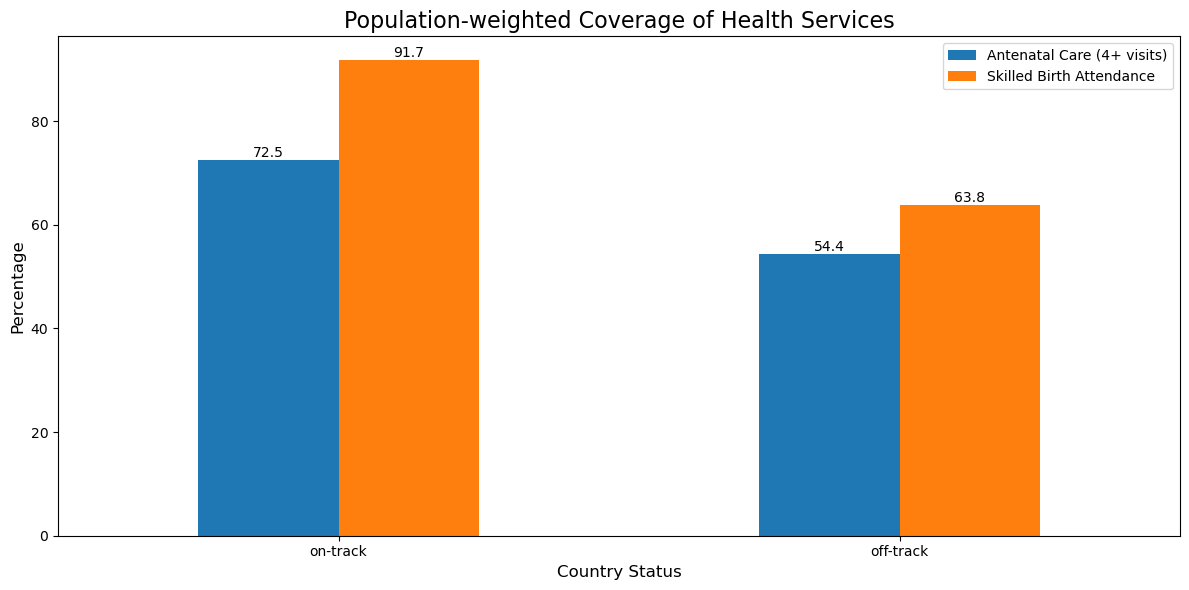

In [19]:
# Create comparison chart
plt.figure(figsize=(12, 6))
results.plot(kind='bar', ax=plt.gca())
plt.title('Population-weighted Coverage of Health Services', fontsize=16)
plt.xlabel('Country Status', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(['Antenatal Care (4+ visits)', 'Skilled Birth Attendance'], fontsize=10)
plt.xticks(rotation=0)
for i in plt.gca().containers:
    plt.gca().bar_label(i, fmt='%.1f', fontsize=10)
plt.tight_layout()
plt.show()



The bar chart above illustrates the population-weighted coverage percentages for two key health services—Antenatal Care (4+ visits) and Skilled Birth Attendance—across on-track and off-track countries:

- **On-Track Countries**:
  - The average population-weighted coverage for ANC4 is **72.5%**.
  - The average population-weighted coverage for SAB is notably higher at **91.7%**.

- **Off-Track Countries**:
  - The average population-weighted coverage for ANC4 drops to **54.4%**.
  - The average population-weighted coverage for SAB also decreases to **63.8%**.

### Interpretation

- **On-Track vs. Off-Track**:
  - There is a clear disparity in health service coverage between on-track and off-track countries. On-track countries have significantly higher coverage for both ANC4 and SAB, indicating better access to essential maternal and newborn health services.
  - The difference is more pronounced for SAB, where on-track countries have nearly a 28% higher coverage rate compared to off-track countries.

- **Policy Implications**:
  - These findings suggest a need for targeted interventions in off-track countries to improve access to both antenatal care and skilled birth attendance, which are critical for reducing under-5 mortality and achieving Sustainable Development Goals.

This visualization underscores the importance of strengthening health systems in off-track countries to ensure that more women and newborns have access to these vital health services.


## Distribution Analysis of ANC4 Values by Country Status

To further explore the differences in antenatal care coverage (ANC4) between on-track and off-track countries, a boxplot was created. This visualization helps to identify the spread and central tendency of ANC4 values within each group.


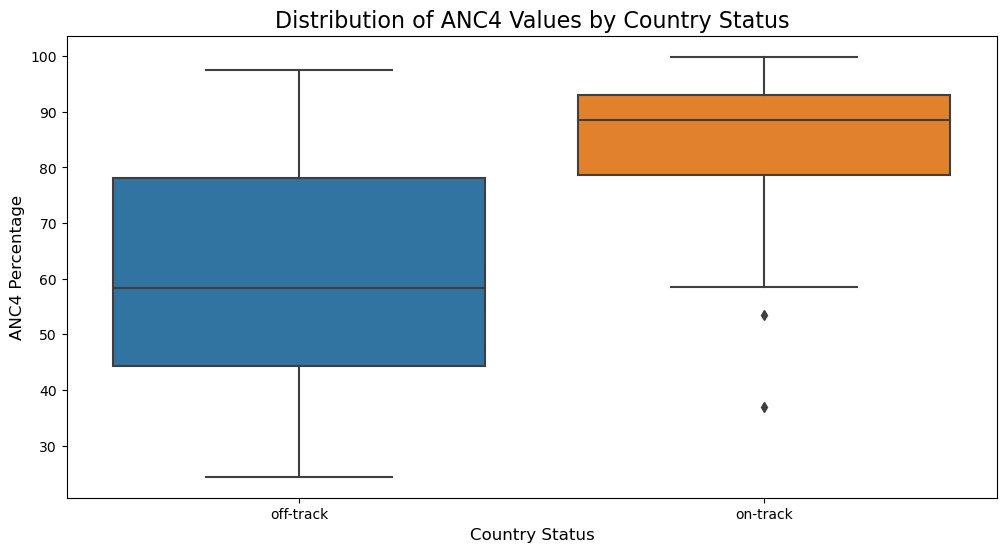

In [20]:

# Analyze distribution of ANC4 and SAB values
plt.figure(figsize=(12, 6))
sns.boxplot(x='Status', y='latest_value_ANC4', data=final_data)
plt.title('Distribution of ANC4 Values by Country Status', fontsize=16)
plt.xlabel('Country Status', fontsize=12)
plt.ylabel('ANC4 Percentage', fontsize=12)
plt.show()


The boxplot above shows the distribution of ANC4 (Antenatal Care with 4+ visits) percentages across countries categorized as on-track and off-track:

- **On-Track Countries**:
  - The median ANC4 coverage for on-track countries is higher, with the majority of values clustered between approximately 75% and 95%.
  - There are a few outliers with lower ANC4 coverage, but these are exceptions rather than the norm.
  
- **Off-Track Countries**:
  - The ANC4 coverage in off-track countries shows greater variability, with a wider interquartile range (IQR) compared to on-track countries.
  - The median coverage is lower, around 60%, and the overall distribution indicates a broader range of coverage levels, including some countries with coverage as low as 30%.

### Interpretation

- **Higher Consistency in On-Track Countries**:
  - On-track countries tend to have more consistent and higher ANC4 coverage rates, reflecting better access to antenatal care services.

- **Greater Variability in Off-Track Countries**:
  - Off-track countries exhibit a wider distribution of ANC4 coverage, indicating that while some countries may have high coverage, others still lag significantly behind. This variability suggests uneven progress and potential disparities in healthcare access within this group.



## Distribution Analysis of SAB Values by Country Status

To further investigate the differences in skilled birth attendance (SAB) coverage between on-track and off-track countries, a boxplot was created. This visualization highlights the spread and central tendency of SAB values within each group.


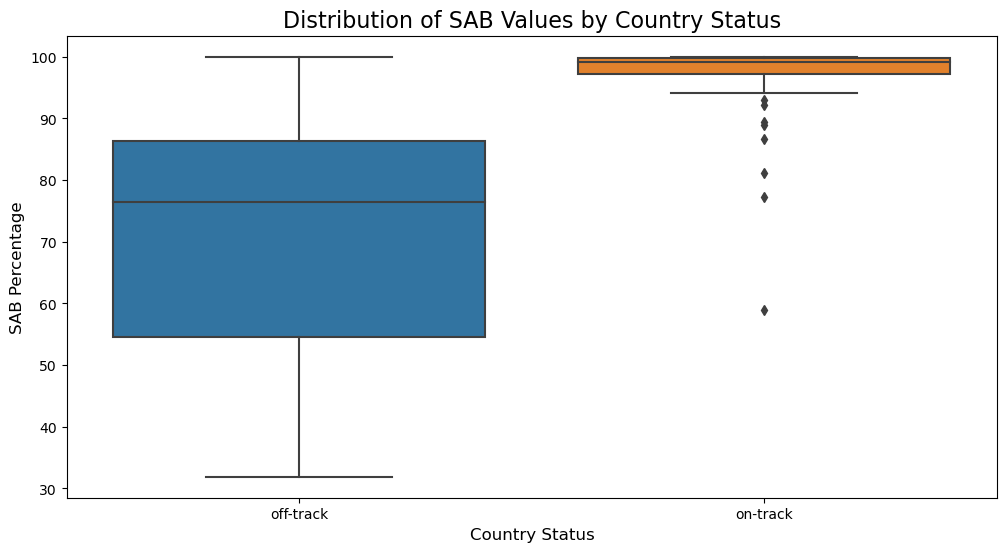

In [21]:

plt.figure(figsize=(12, 6))
sns.boxplot(x='Status', y='latest_value_SAB', data=final_data)
plt.title('Distribution of SAB Values by Country Status', fontsize=16)
plt.xlabel('Country Status', fontsize=12)
plt.ylabel('SAB Percentage', fontsize=12)
plt.show()



The boxplot above shows the distribution of SAB (Skilled Birth Attendance) percentages across countries categorized as on-track and off-track:

- **On-Track Countries**:
  - The median SAB coverage for on-track countries is very high, with most values clustered tightly near 100%.
  - There are several outliers with lower SAB coverage, but these are relatively few compared to the overall distribution.

- **Off-Track Countries**:
  - The SAB coverage in off-track countries shows a broader interquartile range (IQR) compared to on-track countries, with the median around 75%.
  - The distribution indicates that while some off-track countries have relatively high SAB coverage, others have significantly lower values, with the lower quartile extending down to around 60%.

### Interpretation

- **High Consistency in On-Track Countries**:
  - On-track countries demonstrate a highly consistent and elevated SAB coverage, indicating strong healthcare systems capable of providing skilled attendance during childbirth.

- **Variability in Off-Track Countries**:
  - Off-track countries exhibit more variability in SAB coverage, which could reflect disparities in access to skilled healthcare during childbirth. The presence of lower quartile and minimum values suggests that some off-track countries are struggling to provide adequate skilled birth attendance.



## Relationship between ANC4 and SAB Coverage

To explore the relationship between antenatal care (ANC4) and skilled birth attendance (SAB) coverage, a scatterplot was created. This visualization helps to identify correlations and patterns between these two critical health service indicators across on-track and off-track countries.


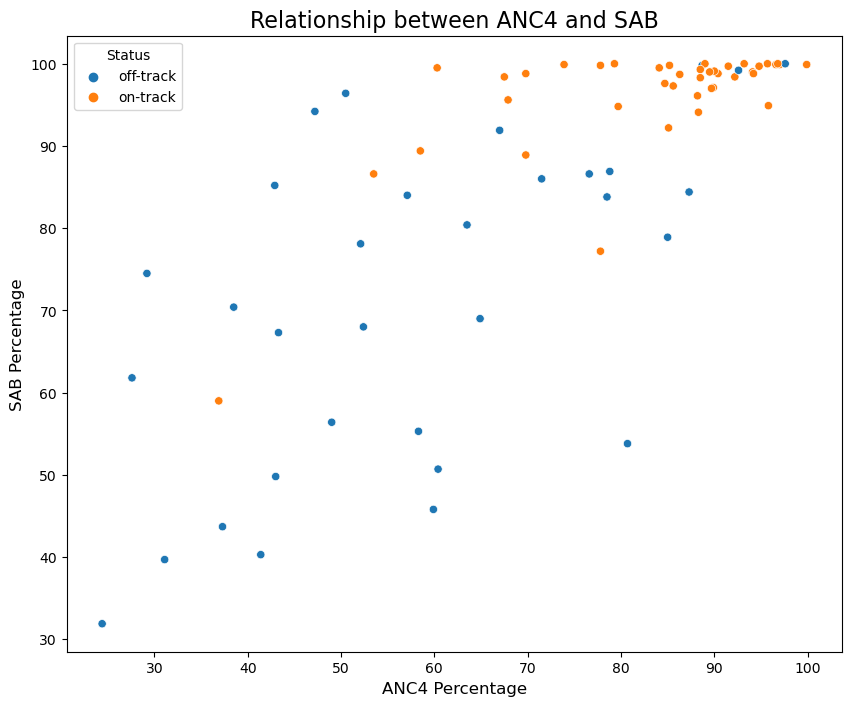

In [22]:

# Analyze relationship between ANC4 and SAB
plt.figure(figsize=(10, 8))
sns.scatterplot(x='latest_value_ANC4', y='latest_value_SAB', hue='Status', data=final_data)
plt.title('Relationship between ANC4 and SAB', fontsize=16)
plt.xlabel('ANC4 Percentage', fontsize=12)
plt.ylabel('SAB Percentage', fontsize=12)
plt.show()


The scatterplot above shows the relationship between ANC4 (Antenatal Care with 4+ visits) and SAB (Skilled Birth Attendance) percentages across countries categorized as on-track and off-track:

- **On-Track Countries**:
  - Represented by orange points, on-track countries generally cluster towards the higher end of both ANC4 and SAB percentages, indicating strong performance in both health service areas.
  - The majority of on-track countries are concentrated in the upper-right quadrant, reflecting high coverage for both indicators.

- **Off-Track Countries**:
  - Represented by blue points, off-track countries display a wider distribution, with many countries spread across lower ANC4 and SAB percentages.
  - There is a noticeable trend where some off-track countries achieve relatively high SAB coverage but lag in ANC4 coverage, suggesting disparities in health service access.

### Interpretation

- **Correlation between ANC4 and SAB**:
  - There appears to be a positive correlation between ANC4 and SAB coverage, with countries that perform well in one indicator often performing well in the other.
  - On-track countries generally exhibit higher coverage for both ANC4 and SAB, indicating more comprehensive maternal and newborn health services.

- **Disparities in Off-Track Countries**:
  - The scatterplot reveals that off-track countries are more likely to have inconsistent coverage between ANC4 and SAB, which may reflect challenges in healthcare infrastructure or access to services.



## Additional Analysis

### Geographical Distribution of Countries without ANC4 Data

The following countries were identified as lacking data on antenatal care with 4+ visits (ANC4). This gap in data could impact the comprehensiveness of the analysis and may indicate regions where data collection or reporting needs improvement.


In [29]:

# Analyze geographical distribution of countries without ANC4 data
countries_without_anc4 = final_data[final_data['latest_value_ANC4'].isna()]['Geographic area'].tolist()
print("\nCountries without ANC4 data:")
print(', '.join(countries_without_anc4))

# Calculate correlation between ANC4 and SAB
correlation = final_data['latest_value_ANC4'].corr(final_data['latest_value_SAB'])
print(f"\nCorrelation between ANC4 and SAB: {correlation:.2f}")

# Calculate average number of births for on-track and off-track countries
mean_births = final_data.groupby('Status')['Births (thousands)'].mean()
print("\nMean number of births (thousands):")
print(mean_births)


Countries without ANC4 data:
Anguilla, Antigua and Barbuda, Australia, Austria, Azerbaijan, Bahamas, Bahrain, Barbados, Belize, Bhutan, Bolivia (Plurinational State of), Bosnia and Herzegovina, Brunei Darussalam, Bulgaria, Burundi, Canada, Chad, Chile, Colombia, Cyprus, Denmark, Dominica, Ecuador, El Salvador, Estonia, Finland, France, Germany, Greece, Iceland, Indonesia, Italy, Jamaica, Japan, Kazakhstan, Kuwait, Lithuania, Malaysia, Malta, Mauritius, Montserrat, New Zealand, Norway, Palau, Panama, Poland, Portugal, Qatar, Republic of Moldova, Romania, Russian Federation, Saint Kitts and Nevis, Saint Lucia, Sao Tome and Principe, Seychelles, Singapore, Slovakia, Spain, United Arab Emirates, United States, Venezuela (Bolivarian Republic of)

Correlation between ANC4 and SAB: 0.75

Mean number of births (thousands):
Status
off-track    1101.582146
on-track      683.303879
Name: Births (thousands), dtype: float64



### Correlation between ANC4 and SAB

The correlation between ANC4 and skilled birth attendance (SAB) was calculated to assess the relationship between these two health service indicators.

- **Correlation between ANC4 and SAB**: **0.75**

This strong positive correlation suggests that countries with higher ANC4 coverage tend to also have higher SAB coverage, indicating a consistent level of access to maternal health services across these two critical areas.

### Average Number of Births (Thousands) by Country Status

The average number of births (in thousands) was calculated separately for on-track and off-track countries to understand the demographic context in which these health services are provided.

#### Mean Number of Births (Thousands):
- **Off-Track Countries**: **1101.58**
- **On-Track Countries**: **683.30**

This result shows that off-track countries, on average, have a higher number of births compared to on-track countries. This demographic difference might imply greater challenges in providing widespread maternal health services in off-track countries, given their larger population sizes.

### Conclusion

- **Data Gaps**: The absence of ANC4 data in many countries, particularly in high-income and geographically diverse regions, highlights areas where improved data collection could enhance the analysis.
- **Correlation**: The strong correlation between ANC4 and SAB indicates that efforts to improve one of these health services are likely to benefit the other, reinforcing the importance of integrated health service delivery.
- **Demographic Differences**: The higher average number of births in off-track countries may present additional challenges for improving health service coverage in these regions, necessitating targeted strategies to manage the larger maternal and child health needs.

These additional analyses provide further insight into the data and contextual factors influencing maternal health service coverage in different countries.


## Gap Analysis between ANC4 and SAB Coverage

To explore the differences between antenatal care (ANC4) and skilled birth attendance (SAB) coverage, a scatterplot was created. This visualization also includes the size of the country's birth population, represented by the size of the points, and a reference line indicating equal coverage for both services.


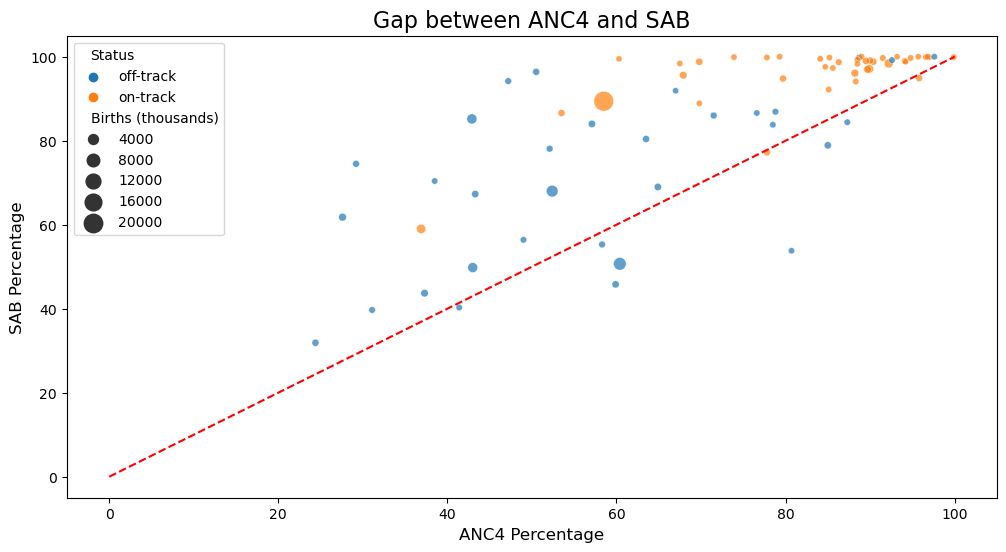

In [37]:
# Analyze the gap between ANC4 and SAB
final_data['gap'] = final_data['latest_value_SAB'] - final_data['latest_value_ANC4']
plt.figure(figsize=(12, 6))
sns.scatterplot(x='latest_value_ANC4', y='latest_value_SAB', hue='Status', size='Births (thousands)', 
                data=final_data, sizes=(20, 200), alpha=0.7)
plt.plot([0, 100], [0, 100], 'r--')  
plt.title('Gap between ANC4 and SAB', fontsize=16)
plt.xlabel('ANC4 Percentage', fontsize=12)
plt.ylabel('SAB Percentage', fontsize=12)
plt.show()


The scatterplot above illustrates the relationship between ANC4 (Antenatal Care with 4+ visits) and SAB (Skilled Birth Attendance) coverage across different countries, with points color-coded by their status (on-track or off-track) and sized according to the number of births:

- **Reference Line**:
  - The red dashed line represents a 1:1 ratio where ANC4 and SAB coverage would be equal. Points above the line indicate higher SAB coverage compared to ANC4, while points below indicate the opposite.

- **On-Track Countries**:
  - Represented by orange points, on-track countries tend to cluster above the reference line, indicating that in many cases, SAB coverage exceeds ANC4 coverage.

- **Off-Track Countries**:
  - Represented by blue points, off-track countries are more widely dispersed, with several points lying below the reference line, suggesting that some countries have better ANC4 coverage than SAB.

- **Point Size**:
  - Larger points indicate countries with higher birth populations. Some large points are found off the line, particularly among off-track countries, suggesting that populous nations may face challenges in providing balanced coverage for both ANC4 and SAB.

### Interpretation

- **General Trends**:
  - The scatterplot reveals that SAB coverage often exceeds ANC4 coverage, especially in on-track countries. This suggests that while many countries have strong systems for ensuring skilled birth attendance, antenatal care services may require further attention and improvement.

- **Disparities in Off-Track Countries**:
  - The variability in the positions of off-track countries, particularly those below the reference line, highlights the inconsistent access to these health services, with some countries having relatively lower SAB coverage despite similar or higher ANC4 coverage.

- **Impact of Population Size**:
  - Countries with larger populations (represented by larger points) show varying gaps between ANC4 and SAB, indicating that demographic factors may influence the ability to deliver these services uniformly.



## Distribution of ANC4 Values

To understand how antenatal care (ANC4) coverage is distributed across on-track and off-track countries, a comparative histogram was created. This visualization highlights the frequency of different ANC4 coverage levels within each group.


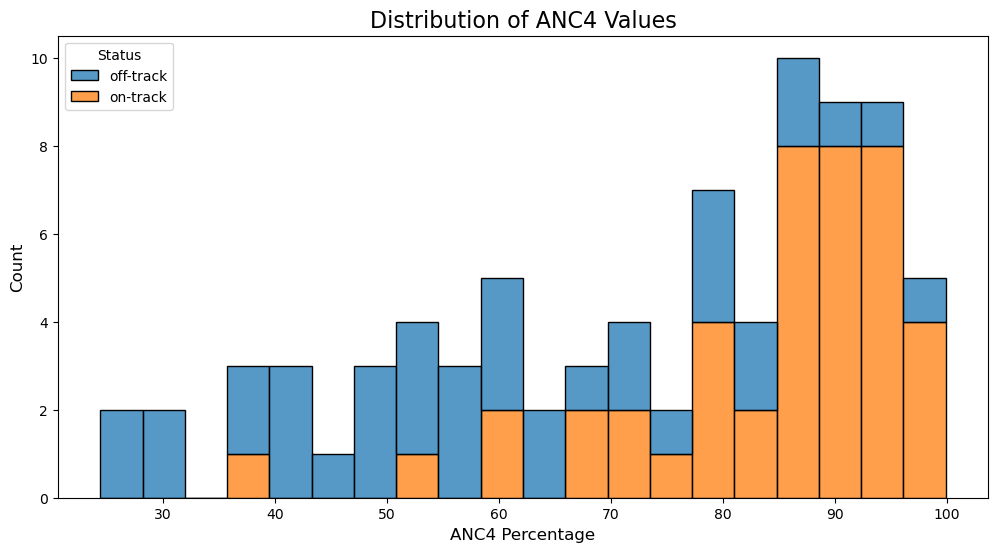

In [38]:

# Comparative histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=final_data, x='latest_value_ANC4', hue='Status', multiple="stack", bins=20)
plt.title('Distribution of ANC4 Values', fontsize=16)
plt.xlabel('ANC4 Percentage', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


The histogram above illustrates the distribution of ANC4 (Antenatal Care with 4+ visits) percentages across countries, with the bars color-coded by their status (on-track or off-track):

- **On-Track Countries**:
  - Represented by orange bars, on-track countries generally exhibit higher ANC4 percentages, with many countries clustered in the 80-100% range. This suggests strong coverage of antenatal care services among these countries.

- **Off-Track Countries**:
  - Represented by blue bars, off-track countries show a wider and more evenly spread distribution, with a significant number of countries having ANC4 coverage below 60%. This indicates variability and, in some cases, lower performance in providing antenatal care.

### Interpretation

- **Higher Coverage in On-Track Countries**:
  - The histogram reveals that on-track countries tend to have higher ANC4 coverage, as evidenced by the concentration of orange bars in the upper ranges of the histogram. This reflects better access to antenatal care services in countries that are progressing well towards the SDG targets.

- **Wide Variability in Off-Track Countries**:
  - Off-track countries show greater variability in ANC4 coverage, with a substantial portion of these countries falling below 60% coverage. This highlights disparities in healthcare provision and suggests the need for targeted improvements in these regions.



## Distribution of SAB Values by Country Status

To visualize the distribution and density of skilled birth attendance (SAB) coverage across on-track and off-track countries, a violin plot was created. This plot provides insights into the spread and central tendency of SAB percentages within each group.


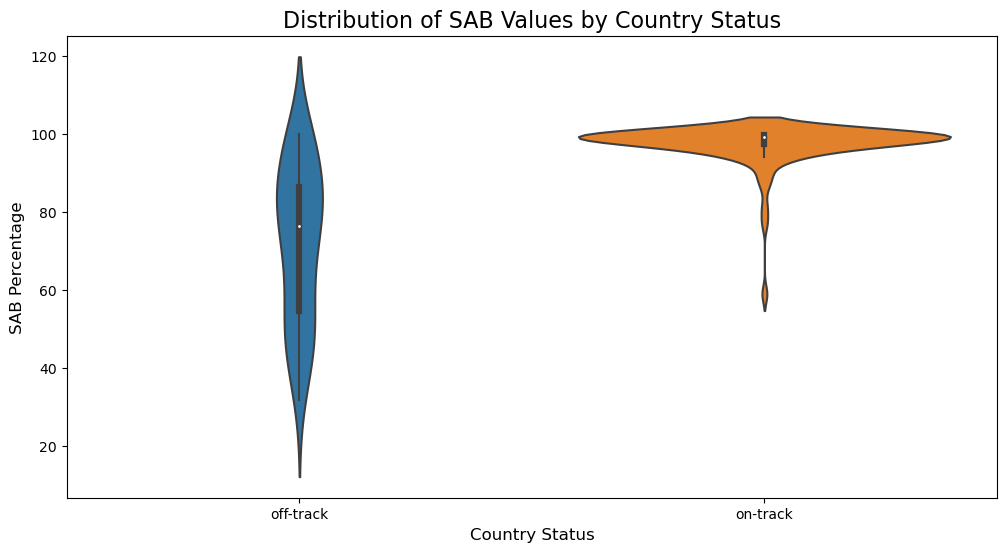

In [39]:

# Violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='Status', y='latest_value_SAB', data=final_data)
plt.title('Distribution of SAB Values by Country Status', fontsize=16)
plt.xlabel('Country Status', fontsize=12)
plt.ylabel('SAB Percentage', fontsize=12)
plt.show()


The violin plot above illustrates the distribution of SAB (Skilled Birth Attendance) percentages across countries, divided by their status (on-track or off-track):

- **On-Track Countries**:
  - Represented by the orange section, on-track countries show a high concentration of SAB values near the top of the scale, around 100%.
  - The distribution is narrower and more uniform, indicating consistent and high levels of SAB coverage across these countries.

- **Off-Track Countries**:
  - Represented by the blue section, off-track countries exhibit a wider distribution of SAB values, with a more elongated shape indicating greater variability in coverage.
  - The plot shows that while some off-track countries achieve high SAB coverage, others are spread out across lower coverage levels, with some countries even below 50%.

### Interpretation

- **Consistency in On-Track Countries**:
  - The violin plot demonstrates that on-track countries generally maintain a high and consistent SAB coverage, which aligns with their progress towards achieving health-related SDG targets.

- **Variability in Off-Track Countries**:
  - The wider and more varied distribution for off-track countries suggests disparities in access to skilled birth attendance. This variability highlights the challenges faced by off-track countries in providing consistent and widespread coverage of skilled birth attendance.



## Relationship between Number of Births and SAB Coverage

To explore the relationship between the number of births and skilled birth attendance (SAB) coverage, a scatterplot was created. This visualization uses a logarithmic scale for the number of births to better understand the distribution and patterns in the data.


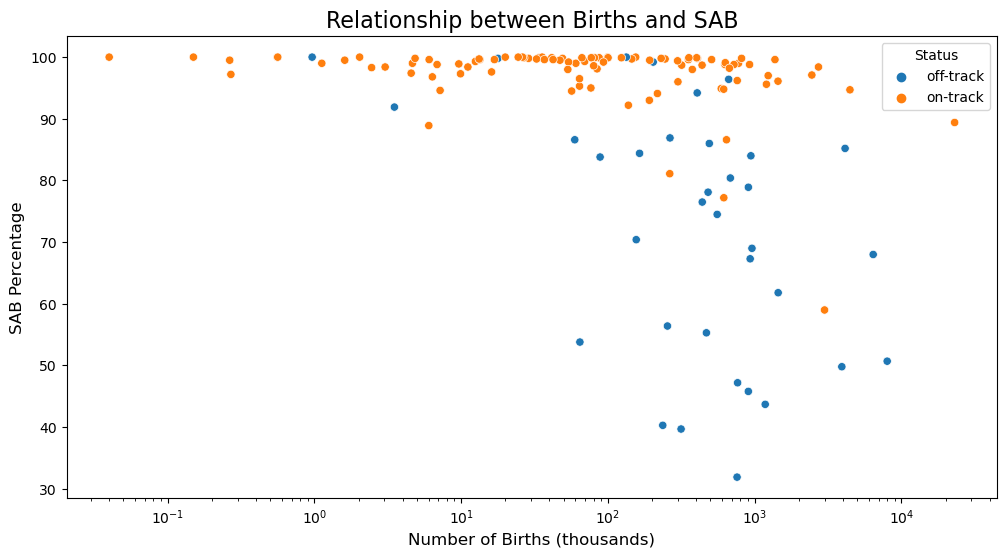

In [40]:

# Analyze relationship with number of births
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Births (thousands)', y='latest_value_SAB', hue='Status', data=final_data)
plt.title('Relationship between Births and SAB', fontsize=16)
plt.xlabel('Number of Births (thousands)', fontsize=12)
plt.ylabel('SAB Percentage', fontsize=12)
plt.xscale('log')  
plt.show()


The scatterplot above illustrates the relationship between the number of births (in thousands) and SAB (Skilled Birth Attendance) percentages across countries, with points color-coded by their status (on-track or off-track):

- **On-Track Countries**:
  - Represented by orange points, on-track countries generally achieve high SAB coverage, even as the number of births increases. The concentration of these points near the top of the plot reflects consistent high performance in providing skilled birth attendance, regardless of population size.

- **Off-Track Countries**:
  - Represented by blue points, off-track countries display more variability in SAB coverage as the number of births increases. There are noticeable drops in SAB coverage, particularly among countries with larger populations, suggesting potential challenges in scaling healthcare services to meet higher demand.

- **Logarithmic Scale**:
  - The x-axis uses a logarithmic scale to capture the wide range of birth counts across different countries. This helps to reveal trends and patterns that might not be as apparent on a linear scale.

### Interpretation

- **High SAB Coverage in On-Track Countries**:
  - On-track countries maintain high levels of SAB coverage across varying population sizes, indicating robust healthcare systems capable of delivering skilled birth attendance at scale.

- **Challenges in Off-Track Countries**:
  - The scatterplot highlights the challenges faced by off-track countries in maintaining SAB coverage, particularly as the number of births increases. The drop in SAB coverage in larger populations suggests a strain on resources and healthcare infrastructure in these countries.



## Analysis of Outlier Countries in SAB Coverage

To identify the top and bottom performers in skilled birth attendance (SAB) coverage, an analysis was conducted to highlight the countries with the highest and lowest SAB percentages. This helps to understand the extremes in healthcare service delivery across different countries.


In [41]:

# Analyze outlier countries
top_performers = final_data.nlargest(5, 'latest_value_SAB')
bottom_performers = final_data.nsmallest(5, 'latest_value_SAB')

print("Top 5 performers in SAB:")
print(top_performers[['Geographic area', 'latest_value_SAB', 'Status']])
print("\nBottom 5 performers in SAB:")
print(bottom_performers[['Geographic area', 'latest_value_SAB', 'Status']])

Top 5 performers in SAB:
             Geographic area  latest_value_SAB     Status
16                      Cuba             100.0   on-track
36                Kyrgyzstan             100.0   on-track
50           North Macedonia             100.0   on-track
71              Turkmenistan             100.0  off-track
72  Turks and Caicos Islands             100.0   on-track

Bottom 5 performers in SAB:
             Geographic area  latest_value_SAB     Status
63                   Somalia              31.9  off-track
64               South Sudan              39.7  off-track
12  Central African Republic              40.3  off-track
48                     Niger              43.7  off-track
39                Madagascar              45.8  off-track


### Results

#### Top 5 Performers in SAB Coverage:

| Geographic Area          | SAB Percentage | Status    |
|--------------------------|----------------|-----------|
| Cuba                      | 100.0%         | on-track  |
| Kyrgyzstan                | 100.0%         | on-track  |
| North Macedonia           | 100.0%         | on-track  |
| Turkmenistan              | 100.0%         | off-track |
| Turks and Caicos Islands  | 100.0%         | on-track  |

- **Top Performers**: 
  - All top performers achieved a perfect SAB coverage rate of 100%. Most of these countries are on-track, reflecting their strong healthcare systems and commitment to providing skilled birth attendance.
  - Interestingly, Turkmenistan, despite being categorized as off-track, also achieved 100% SAB coverage, suggesting that specific aspects of their healthcare system are performing exceptionally well.

#### Bottom 5 Performers in SAB Coverage:

| Geographic Area                | SAB Percentage | Status    |
|--------------------------------|----------------|-----------|
| Somalia                        | 31.9%          | off-track |
| South Sudan                    | 39.7%          | off-track |
| Central African Republic       | 40.3%          | off-track |
| Niger                          | 43.7%          | off-track |
| Madagascar                     | 45.8%          | off-track |

- **Bottom Performers**:
  - The bottom performers all have SAB coverage rates below 50%, with Somalia having the lowest at 31.9%.
  - All of these countries are off-track, indicating significant challenges in providing skilled birth attendance. These low coverage rates may reflect issues such as limited healthcare infrastructure, political instability, or socioeconomic barriers.

### Interpretation

- **High Performers**:
  - The consistent high performance in SAB coverage among the top performers, particularly in on-track countries, demonstrates the effectiveness of their healthcare systems in ensuring that childbirth is attended by skilled personnel.
  - The inclusion of an off-track country (Turkmenistan) among the top performers suggests that even within broader struggles, specific successes in healthcare delivery are possible.

- **Low Performers**:
  - The low SAB coverage in the bottom-performing countries highlights the urgent need for targeted interventions to improve maternal health services in these regions. The fact that all these countries are off-track underscores the link between low SAB coverage and challenges in meeting broader health-related Sustainable Development Goals (SDGs).




## Distribution of ANC4 to SAB Ratio by Country Status

To explore the balance between antenatal care (ANC4) and skilled birth attendance (SAB) across countries, the ratio of ANC4 to SAB was calculated and visualized using a boxplot. This ratio provides insights into how evenly these two critical health services are provided relative to each other.


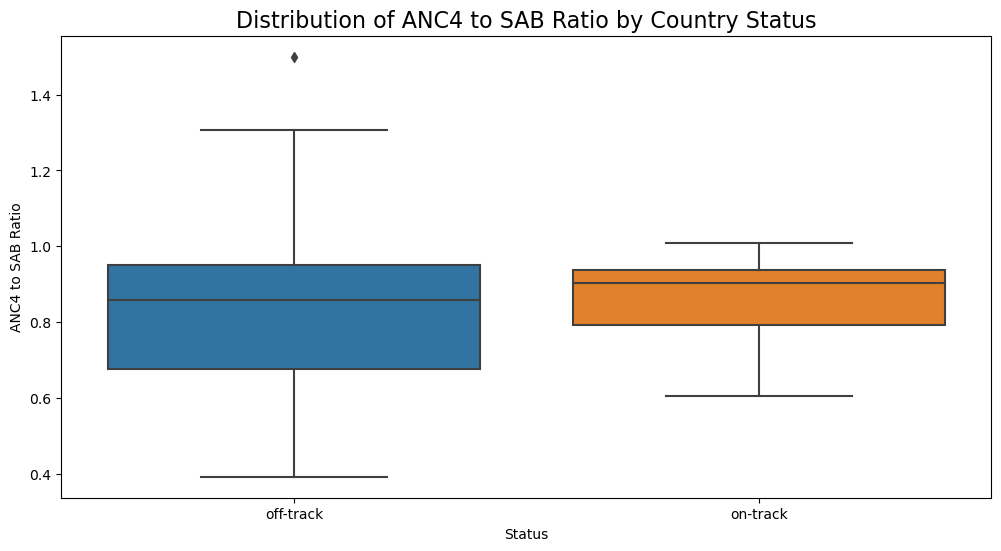

In [42]:
# Analyze ANC4 to SAB ratio
final_data['ANC4_SAB_ratio'] = final_data['latest_value_ANC4'] / final_data['latest_value_SAB']
plt.figure(figsize=(12, 6))
sns.boxplot(x='Status', y='ANC4_SAB_ratio', data=final_data)
plt.title('Distribution of ANC4 to SAB Ratio by Country Status', fontsize=16)
plt.ylabel('ANC4 to SAB Ratio')
plt.show()


The boxplot above illustrates the distribution of the ANC4 to SAB ratio across countries, categorized by their status as on-track or off-track:

- **On-Track Countries**:
  - Represented by the orange box, on-track countries generally have a tighter distribution of ANC4 to SAB ratios, centered around a value slightly below 1. This suggests that these countries are fairly balanced in their provision of antenatal care and skilled birth attendance.

- **Off-Track Countries**:
  - Represented by the blue box, off-track countries show a wider range of ANC4 to SAB ratios, with some countries having significantly lower ratios, indicating that in these cases, ANC4 coverage is much lower relative to SAB coverage.
  - The presence of an outlier above the 1.0 ratio indicates that some off-track countries have better ANC4 coverage relative to SAB, but this is not common.

### Interpretation

- **Balanced Coverage in On-Track Countries**:
  - The narrow distribution of ANC4 to SAB ratios in on-track countries reflects a more consistent and balanced approach to maternal health services. These countries tend to provide both antenatal care and skilled birth attendance at similar levels.

- **Variability in Off-Track Countries**:
  - The wider range of ratios in off-track countries highlights disparities in the delivery of these services. The fact that many off-track countries have ratios significantly below 1.0 suggests that while skilled birth attendance might be relatively better provided, antenatal care lags behind.



## Correlation Analysis

To understand the relationships between antenatal care (ANC4), skilled birth attendance (SAB), and the number of births, a correlation analysis was performed. The results are visualized in a heatmap, which highlights the strength and direction of these relationships.


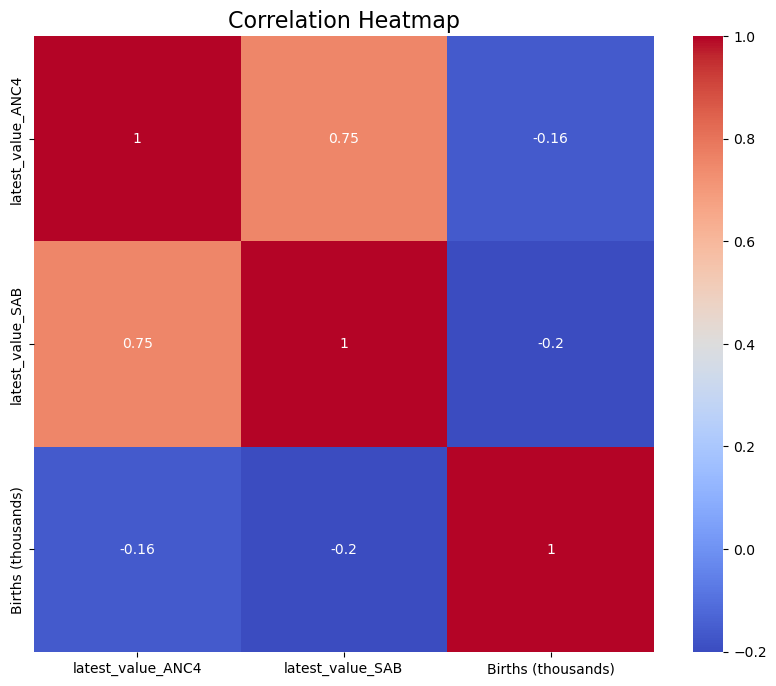

In [43]:

# Correlation analysis
correlation_matrix = final_data[['latest_value_ANC4', 'latest_value_SAB', 'Births (thousands)']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap', fontsize=16)
plt.show()


The heatmap above shows the correlation coefficients between the following variables:

- **ANC4 (latest_value_ANC4)**: Percentage of women who received antenatal care with 4+ visits.
- **SAB (latest_value_SAB)**: Percentage of births attended by skilled health personnel.
- **Births (thousands)**: Number of births in thousands.

### Key Findings

- **Correlation between ANC4 and SAB**: **0.75**
  - There is a strong positive correlation between ANC4 and SAB, indicating that countries with higher antenatal care coverage tend to also have higher skilled birth attendance coverage. This suggests that improvements in one area are likely to be associated with improvements in the other.

- **Correlation between Births and ANC4**: **-0.16**
  - The correlation between the number of births and ANC4 coverage is slightly negative, but weak. This suggests that in general, the number of births does not have a strong influence on antenatal care coverage, though the negative sign may indicate a slight trend where countries with more births have slightly lower ANC4 coverage.

- **Correlation between Births and SAB**: **-0.20**
  - The correlation between the number of births and SAB coverage is also slightly negative, and slightly stronger than the correlation with ANC4. This indicates that countries with larger populations might face more challenges in maintaining high levels of skilled birth attendance, though the relationship is still relatively weak.

### Interpretation

- **Strong Correlation between ANC4 and SAB**:
  - The strong correlation between ANC4 and SAB highlights the interconnectedness of these two health services. Efforts to improve antenatal care are likely to also benefit skilled birth attendance, and vice versa.

- **Weak Influence of Birth Numbers**:
  - The weak negative correlations between the number of births and both ANC4 and SAB suggest that while larger populations might present challenges, these factors alone do not strongly determine coverage levels. Other factors, such as healthcare infrastructure and policy, may play more significant roles.




## Cluster Analysis of Countries based on ANC4, SAB, and Births

To identify patterns and groupings among countries based on their antenatal care (ANC4), skilled birth attendance (SAB), and birth population size, a cluster analysis was conducted using K-means clustering. This analysis helps to categorize countries into distinct groups with similar characteristics.


In [44]:

# Cluster analysis
# Normalize data
from sklearn.preprocessing import StandardScaler
features = ['latest_value_ANC4', 'latest_value_SAB', 'Births (thousands)']
X = final_data[features].dropna()
X_scaled = StandardScaler().fit_transform(X)


c:\Users\mashhadcom.com\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\mashhadcom.com\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


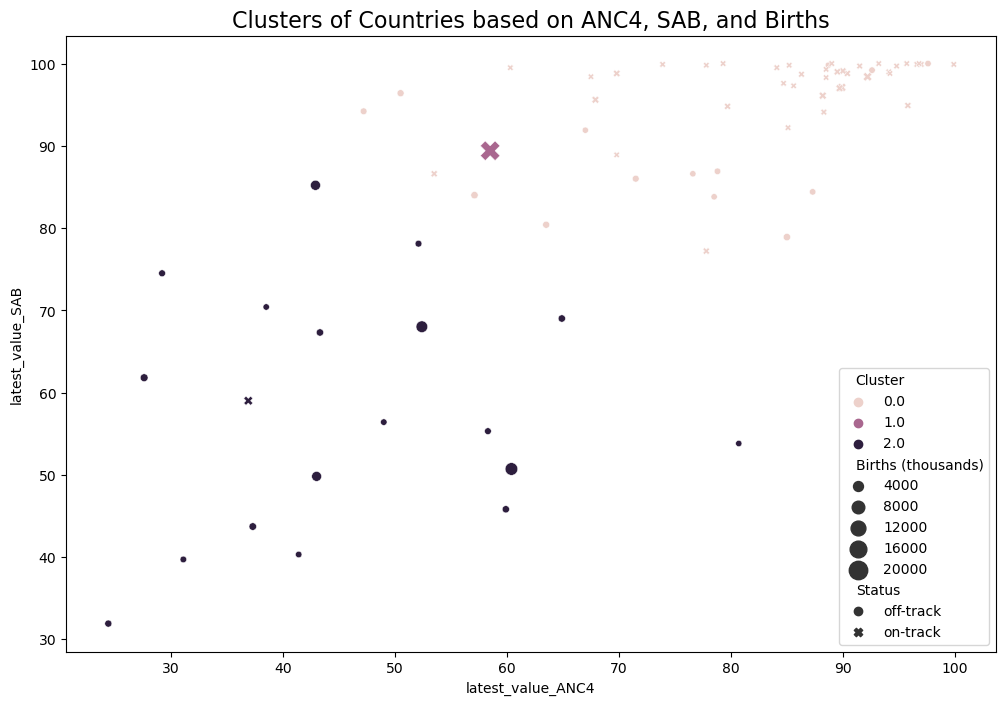

In [45]:

# Run K-means
kmeans = KMeans(n_clusters=3, random_state=42)
final_data.loc[X.index, 'Cluster'] = kmeans.fit_predict(X_scaled)

# Display clustering results
plt.figure(figsize=(12, 8))
sns.scatterplot(data=final_data, x='latest_value_ANC4', y='latest_value_SAB', 
                hue='Cluster', style='Status', size='Births (thousands)', sizes=(20, 200))
plt.title('Clusters of Countries based on ANC4, SAB, and Births', fontsize=16)
plt.show()


The scatterplot above illustrates the clustering results, showing how countries are grouped based on their ANC4 coverage, SAB coverage, and the number of births. The points are color-coded by their cluster assignment, with additional differentiation by the status (on-track or off-track) and the size of the points representing the number of births.

- **Cluster 0 (Light Pink)**:
  - Countries in this cluster generally have higher ANC4 and SAB coverage, with most of these countries being on-track. This cluster represents countries with well-developed maternal health services.

- **Cluster 1 (Purple)**:
  - This cluster includes countries with intermediate to high coverage in both ANC4 and SAB, but with larger populations. The cluster also includes a mix of on-track and off-track countries, indicating varying levels of healthcare infrastructure relative to population size.

- **Cluster 2 (Dark Purple/Black)**:
  - Countries in this cluster tend to have lower ANC4 and SAB coverage, with most being off-track. This cluster represents countries facing significant challenges in maternal healthcare provision, often with larger populations.

### Interpretation

- **High-Performing Cluster (Cluster 0)**:
  - The countries in Cluster 0 are characterized by high ANC4 and SAB coverage, typically with smaller birth populations. These countries are likely to have well-established healthcare systems that support both antenatal care and skilled birth attendance.

- **Mixed Performance Cluster (Cluster 1)**:
  - Cluster 1 contains countries with varying performance levels, particularly in relation to their population size. While some countries in this cluster manage to maintain relatively high coverage despite larger populations, others may struggle with healthcare access due to demographic pressures.

- **Low-Performing Cluster (Cluster 2)**:
  - Cluster 2 highlights the countries with the greatest need for improvement, as they generally have lower coverage rates and larger populations. These countries are mostly off-track and may require targeted interventions to enhance maternal health services.



In [46]:

# Countries with the largest gap between ANC4 and SAB
final_data['ANC4_SAB_gap'] = final_data['latest_value_SAB'] - final_data['latest_value_ANC4']
top_gap_countries = final_data.nlargest(10, 'ANC4_SAB_gap')
print("Countries with the largest gap between SAB and ANC4:")
print(top_gap_countries[['Geographic area', 'latest_value_ANC4', 'latest_value_SAB', 'ANC4_SAB_gap', 'Status']])

# 5. Analyze outlier countries
def find_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

anc4_outliers = find_outliers(final_data, 'latest_value_ANC4')
sab_outliers = find_outliers(final_data, 'latest_value_SAB')

print("\nOutliers in ANC4:")
print(anc4_outliers[['Geographic area', 'latest_value_ANC4', 'Status']])
print("\nOutliers in SAB:")
print(sab_outliers[['Geographic area', 'latest_value_SAB', 'Status']])

Countries with the largest gap between SAB and ANC4:
                     Geographic area  latest_value_ANC4  latest_value_SAB   
57                            Rwanda               47.2              94.2  \
40                            Malawi               50.5              96.4   
60                           Senegal               29.2              74.5   
18  Democratic Republic of the Congo               42.9              85.2   
73                            Tuvalu               60.3              99.5   
0                        Afghanistan               27.6              61.8   
45                           Morocco               53.5              86.6   
42                        Mauritania               38.5              70.4   
30                             India               58.5              89.4   
66                          Suriname               67.5              98.4   

    ANC4_SAB_gap     Status  
57          47.0  off-track  
40          45.9  off-track  
60       

### Countries with the Largest Gap between SAB and ANC4:

| Geographic Area                         | ANC4 Percentage | SAB Percentage | ANC4 to SAB Gap | Status    |
|-----------------------------------------|-----------------|----------------|-----------------|-----------|
| Rwanda                                  | 47.2%           | 94.2%          | 47.0            | off-track |
| Malawi                                  | 50.5%           | 96.4%          | 45.9            | off-track |
| Senegal                                 | 29.2%           | 74.5%          | 45.3            | off-track |
| Democratic Republic of the Congo        | 42.9%           | 85.2%          | 42.3            | off-track |
| Tuvalu                                  | 60.3%           | 99.5%          | 39.2            | on-track  |
| Afghanistan                             | 27.6%           | 61.8%          | 34.2            | off-track |
| Morocco                                 | 53.5%           | 86.6%          | 33.1            | on-track  |
| Mauritania                              | 38.5%           | 70.4%          | 31.9            | off-track |
| India                                   | 58.5%           | 89.4%          | 30.9            | on-track  |
| Suriname                                | 67.5%           | 98.4%          | 30.9            | on-track  |

- **Interpretation**:
  - These countries exhibit significant gaps between SAB and ANC4 coverage, with SAB percentages being much higher than ANC4. This suggests that while skilled birth attendance is relatively accessible, antenatal care might be lagging, indicating potential imbalances in maternal healthcare services.
  - Most of these countries are off-track, highlighting that disparities in healthcare access could be contributing to their challenges in meeting broader health-related goals.

## Outlier Analysis in ANC4 and SAB

Outliers in ANC4 and SAB were identified to understand which countries significantly deviate from the norm, either by underperforming or, less commonly, by overperforming relative to other countries.

### Outliers in ANC4:

| Geographic Area                         | ANC4 Percentage | Status    |
|-----------------------------------------|-----------------|-----------|
| Senegal                                 | 74.5%           | off-track |
| Somalia                                 | 31.9%           | off-track |
| South Sudan                             | 39.7%           | off-track |
| Chad                                    | 47.2%           | off-track |

- **Interpretation**:
  - The countries identified as outliers in ANC4 generally have low coverage, with most of them being off-track. This indicates severe challenges in providing adequate antenatal care, which may be due to various factors such as healthcare infrastructure, political instability, or socioeconomic barriers.

### Outliers in SAB:

| Geographic Area                         | SAB Percentage  | Status    |
|-----------------------------------------|-----------------|-----------|
| Senegal                                 | 74.5%           | off-track |
| Somalia                                 | 31.9%           | off-track |
| South Sudan                             | 39.7%           | off-track |
| Chad                                    | 47.2%           | off-track |

- **Interpretation**:
  - Similar to ANC4, these outliers in SAB are also primarily off-track countries. The low skilled birth attendance rates in these countries further underline the critical gaps in maternal healthcare services that need to be addressed.



## Discussion and Conclusion

### Discussion

The analysis conducted on antenatal care (ANC4) and skilled birth attendance (SAB) coverage across various countries provides critical insights into the state of maternal health services globally. Several key findings emerge from the analysis:

- **Disparities Between ANC4 and SAB**: The analysis revealed significant disparities between ANC4 and SAB coverage in many countries, particularly those classified as off-track. While some countries have managed to ensure high SAB coverage, their ANC4 coverage lags behind, indicating an imbalance in maternal health service provision. This gap could lead to missed opportunities for early intervention during pregnancy, which is crucial for preventing complications during childbirth.

- **Correlation Between ANC4 and SAB**: A strong positive correlation between ANC4 and SAB suggests that improvements in one area are likely to benefit the other. This interdependency underscores the importance of integrated healthcare strategies that simultaneously enhance both antenatal care and skilled birth attendance to improve overall maternal and newborn health outcomes.

- **Impact of Population Size**: The weak negative correlations between the number of births and both ANC4 and SAB coverage suggest that larger populations may present additional challenges in maintaining high coverage rates. Countries with larger populations, particularly those that are off-track, may require more substantial healthcare infrastructure and resources to ensure equitable access to maternal health services.

- **Cluster Analysis**: The cluster analysis categorized countries into distinct groups based on their ANC4 and SAB coverage, as well as their population sizes. This clustering highlighted that countries with low coverage rates and larger populations face the most significant challenges, particularly those in Cluster 2. These findings suggest that tailored interventions are necessary to address the unique needs of these countries.

- **Outliers and Largest Gaps**: Identifying countries with the largest gaps between ANC4 and SAB, as well as those that are outliers in either service, highlighted regions where maternal healthcare is particularly imbalanced. For instance, countries like Rwanda and Malawi exhibit large gaps, with SAB coverage far outpacing ANC4. These disparities could be indicative of systemic issues within healthcare systems that prioritize certain services over others.

### Conclusion

The findings from this analysis underscore the need for a more balanced and comprehensive approach to maternal health services, particularly in off-track countries. While some nations have made significant strides in providing skilled birth attendance, the gaps in antenatal care coverage remain a critical concern. Addressing these gaps is essential for improving maternal and newborn health outcomes and for achieving the Sustainable Development Goals (SDGs) related to health.

Policymakers and healthcare providers should focus on the following key areas:

1. **Integrated Health Strategies**: Develop and implement integrated strategies that enhance both ANC4 and SAB coverage simultaneously. This could involve strengthening healthcare infrastructure, training more healthcare workers, and ensuring that both antenatal and childbirth services are accessible and affordable.

2. **Targeted Interventions for Off-Track Countries**: Off-track countries, particularly those identified in Cluster 2, should be prioritized for targeted interventions. These countries may require additional resources, international support, and policy reforms to address the systemic barriers to healthcare access.

3. **Addressing Gaps in Data**: The analysis also highlighted gaps in data for some countries, particularly for ANC4. Improving data collection and reporting mechanisms is crucial for accurately monitoring progress and for making informed decisions about where to allocate resources.

4. **Focus on Equity**: Finally, efforts should be made to ensure that all populations, regardless of size, have equitable access to maternal health services. This includes addressing disparities within countries, where certain regions or communities may have significantly lower coverage than others.

In conclusion, while progress has been made in improving maternal health services globally, significant challenges remain, particularly in ensuring that antenatal care and skilled birth attendance are both accessible and of high quality. By focusing on the key areas identified in this analysis, countries can work towards closing the gaps in maternal healthcare and achieving better health outcomes for women and children worldwide.

